In [1]:
!pip -q install torch torchvision timm scikit-learn matplotlib

import torch, timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from copy import deepcopy


In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dino = timm.create_model("vit_small_patch16_224.dino", pretrained=True, num_classes=0).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

In [4]:
def extract_features(model, loader):
    feats, labels = [], []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            z = model(x)
            feats.append(z.cpu().numpy())
            labels.append(y.numpy())
    return np.concatenate(feats), np.concatenate(labels)

X_train_T1, y_train_T1 = extract_features(dino, train_loader)
X_test_T1, y_test_T1   = extract_features(dino, test_loader)


In [5]:
transform_shift = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

train_data_T2 = datasets.CIFAR10(root="./data", train=True, download=False, transform=transform_shift)
train_loader_T2 = torch.utils.data.DataLoader(train_data_T2, batch_size=64, shuffle=True)

X_train_T2, y_train_T2 = extract_features(dino, train_loader_T2)


In [6]:
alpha = 0.7  # balance factor between old and new features
X_train_adaptive = alpha * X_train_T1 + (1 - alpha) * X_train_T2
y_train_adaptive = y_train_T1


In [7]:
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_adaptive, y_train_adaptive)
acc = accuracy_score(y_test_T1, clf.predict(X_test_T1))
print("Adaptive Self-Organized Representation Accuracy:", acc)


Adaptive Self-Organized Representation Accuracy: 0.9144


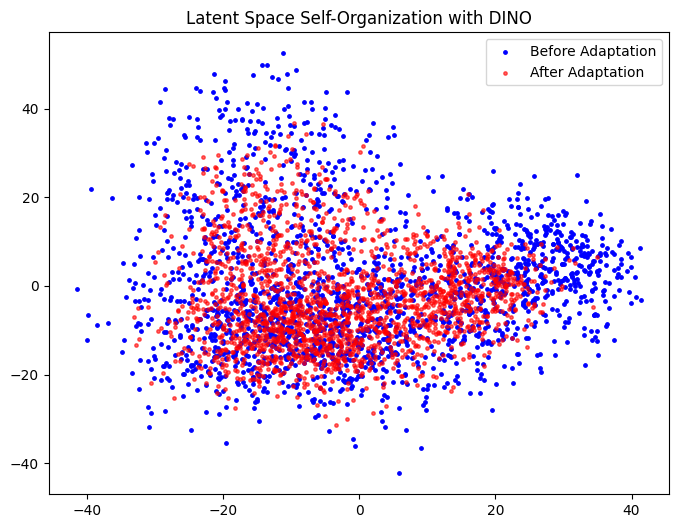

In [8]:
pca = PCA(n_components=2)
Z1 = pca.fit_transform(X_train_T1[:2000])
Z2 = pca.transform(X_train_adaptive[:2000])

plt.figure(figsize=(8,6))
plt.scatter(Z1[:,0], Z1[:,1], c="blue", s=6, label="Before Adaptation")
plt.scatter(Z2[:,0], Z2[:,1], c="red", s=6, alpha=0.6, label="After Adaptation")
plt.legend()
plt.title("Latent Space Self-Organization with DINO")
plt.show()
